<a href="https://colab.research.google.com/github/obeabi/Stocks_TSA/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [520]:
!pip install pandas_ta


In [521]:
import logging
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [522]:
# Importing the Keras libraries and packages
import keras
print(keras.__version__)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

2.15.0


## Fetch & Load the data

In [523]:
# Fetch historical stock data using yfinance
ticker = 'SMLR'
df = yf.download(ticker, start='2021-01-01', end='2024-01-03')

# Calculate technical indicators (RSI, MACD) using pandas_ta
df.ta.rsi(close="Close", append=True)
df.ta.macd(close="Close", append=True)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,,,,,,,,,,
2021-01-04,95.000000,95.000000,88.180000,91.779999,91.779999,15000,NaN,NaN,NaN,NaN
2021-01-05,94.000000,94.000000,92.000000,93.000000,93.000000,16400,NaN,NaN,NaN,NaN
2021-01-06,93.500000,94.500000,92.000000,92.000000,92.000000,9400,NaN,NaN,NaN,NaN
2021-01-07,94.500000,94.500000,90.120003,93.000000,93.000000,33400,NaN,NaN,NaN,NaN
2021-01-08,90.290001,90.940002,88.000000,88.989998,88.989998,15200,NaN,NaN,NaN,NaN


In [524]:
# Assuming df is your DataFrame with a 'Date' column

# Determine the split index based on the last two days
split_index = len(df) - 20

# Split the DataFrame into training and test sets
dataset_train = df.iloc[:split_index]
dataset_test  = df.iloc[split_index:]


dataset_train.head()

,Open,High,Low,Close,Adj Close,Volume,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,,,,,,,,,,
2021-01-04,95.000000,95.000000,88.180000,91.779999,91.779999,15000,NaN,NaN,NaN,NaN
2021-01-05,94.000000,94.000000,92.000000,93.000000,93.000000,16400,NaN,NaN,NaN,NaN
2021-01-06,93.500000,94.500000,92.000000,92.000000,92.000000,9400,NaN,NaN,NaN,NaN
2021-01-07,94.500000,94.500000,90.120003,93.000000,93.000000,33400,NaN,NaN,NaN,NaN
2021-01-08,90.290001,90.940002,88.000000,88.989998,88.989998,15200,NaN,NaN,NaN,NaN


In [525]:
# Specify the names of the two columns
column1 = 'Open'
column2 = 'Close'

# Create a new column with the average
#dataset_train['Open'] = dataset_train[[column1, column2]].mean(axis=1)
#dataset_test['Open'] = dataset_test[[column1, column2]].mean(axis=1)

# You can use 'Open' rather than 'Price'
features = ['Open','Close', 'Volume', 'RSI_14']
#features = ['Open', 'Close', 'Volume']
#features = ['Open','price', 'Close', 'Volume', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9','MACDs_12_26_9']

dataset_train= dataset_train[features].copy()
dataset_test= dataset_test[features].copy()
no_indicators = len(features)


# Drop rows with missing data
dataset_train.dropna(inplace= True)
# Fill missing values in columns 'A' and 'B' using backfill
#columns_to_fill = features
#dataset_train[columns_to_fill] = dataset_train[columns_to_fill].fillna(method='bfill')


train_features = dataset_train.iloc[:, 0:].values


dataset_train.head()

,Open,Close,Volume,RSI_14
Date,,,,
2021-01-25,88.500000,88.250000,12400,44.584193
2021-01-26,89.500000,90.000000,18800,49.638977
2021-01-27,89.000000,90.000000,60600,49.638977
2021-01-28,86.519997,89.919998,161600,49.400071
2021-01-29,89.919998,88.879997,5900,46.281667


### Feature Scaling

In [526]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_features)

print("The length of the sacled data is :" ,len(training_set_scaled) )
print()
training_set_scaled[0:5]

The length of the sacled data is : 720



array([[0.52525636, 0.52765662, 0.0126568 , 0.38574697],
       [0.53285226, 0.54104504, 0.01988925, 0.46519974],
       [0.52905431, 0.54104504, 0.06712623, 0.46519974],
       [0.51021646, 0.54043298, 0.18126342, 0.46144453],
       [0.53604252, 0.53247643, 0.00531133, 0.41242842]])

### Creating a data structure with 180 timesteps and 1 output

In [527]:
day_lag = 60
X_train = []
y_train = []
for i in range(day_lag, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-day_lag:i, 0:])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping the dataset to add more indicators

In [528]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], no_indicators))

In [529]:
print("Shape of X_train after reshaping:", X_train.shape)

Shape of X_train after reshaping: (660, 60, 4)


## Part 2 - Building and Training the RNN

### Initialising the RNN

In [530]:
regressor = Sequential()

### Adding the first LSTM layer and some Dropout regularisation

In [531]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], no_indicators)))
regressor.add(Dropout(0.2))

### Adding a second LSTM layer and some Dropout regularisation

In [532]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [533]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [534]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Adding the output layer

In [535]:
regressor.add(Dense(units = 1))

### Compiling the RNN

In [536]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Fitting the RNN to the Training set

In [537]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
21/21 [==============================] - 12s 112ms/step - loss: 0.0313
Epoch 2/100
21/21 [==============================] - 2s 112ms/step - loss: 0.0059
Epoch 3/100
21/21 [==============================] - 2s 111ms/step - loss: 0.0051
Epoch 4/100
21/21 [==============================] - 3s 158ms/step - loss: 0.0045
Epoch 5/100
21/21 [==============================] - 2s 114ms/step - loss: 0.0046
Epoch 6/100
21/21 [==============================] - 2s 112ms/step - loss: 0.0041
Epoch 7/100
21/21 [==============================] - 2s 114ms/step - loss: 0.0042
Epoch 8/100
21/21 [==============================] - 2s 113ms/step - loss: 0.0040
Epoch 9/100
21/21 [==============================] - 3s 162ms/step - loss: 0.0040
Epoch 10/100
21/21 [==============================] - 2s 112ms/step - loss: 0.0036
Epoch 11/100
21/21 [==============================] - 2s 114ms/step - loss: 0.0033
Epoch 12/100
21/21 [==============================] - 2s 113ms/step - loss: 0.0034
Epoch 13/100

## Part 3 - Making the predictions and visualising the results

In [538]:
# Drop rows with missing data
#dataset_test[columns_to_fill] = dataset_test[columns_to_fill].fillna(method='bfill')
dataset_test.head()

,Open,Close,Volume,RSI_14
Date,,,,
2023-12-04,40.529999,40.730000,79800,71.789527
2023-12-05,41.000000,41.910000,101000,74.352626
2023-12-06,42.240002,42.549999,69000,75.645105
2023-12-07,42.080002,43.660000,56400,77.740317
2023-12-08,43.490002,45.049999,66200,80.054333


In [539]:
# Plot a line chart using Plotly Express
fig = px.line(dataset_test, x=dataset_test.index, y='Open', title='Stock Price Over Time')

# Show the plot
fig.show()

In [540]:
# if Open price use this
real_stock_price = dataset_test.iloc[:, 0:1].values

# if Avergae price use this
#real_stock_price = dataset_test.iloc[:, -1:].values
real_stock_price[0:5]

array([[40.52999878],
       [41.        ],
       [42.24000168],
       [42.08000183],
       [43.49000168]])

In [541]:
len(dataset_test)

20

### Getting the predicted stock price

In [542]:
# You can use 'Open'rather than 'Price'
dataset_total = pd.concat((dataset_train[features], dataset_test[features]), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - day_lag:].values
print("Shape of inputs before reshaping:", inputs.shape)
inputs = inputs.reshape(-1,no_indicators)
print("\nShape of inputs after reshaping:", inputs.shape)
inputs = sc.transform(inputs)

# Account for the 3D structure required by the LSTM
X_test = []
for i in range(day_lag, day_lag + len(dataset_test)):
    X_test.append(inputs[i-day_lag:i, 0:])


X_test = np.array(X_test)
print("Shape of X_test before reshaping:", X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], no_indicators))
print("\nShape of X_test after reshaping:", X_test.shape)
predicted_stock_price = regressor.predict(X_test)


# Concatenate each entry with zero individually
# Replace `x` with the desired number of zeros
num_zeros = no_indicators- 1
predicted_stock_price = np.array([np.concatenate((entry, np.zeros(num_zeros))) for entry in predicted_stock_price])



# Apply inverse_transform to concatenated_results
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Extract the first element from each entry (model predictions)
model_predictions = predicted_stock_price[:, 0]


Shape of inputs before reshaping: (80, 4)

Shape of inputs after reshaping: (80, 4)
Shape of X_test before reshaping: (20, 60, 4)

Shape of X_test after reshaping: (20, 60, 4)
1/1 [==============================] - 2s 2s/step


### Visualising the results

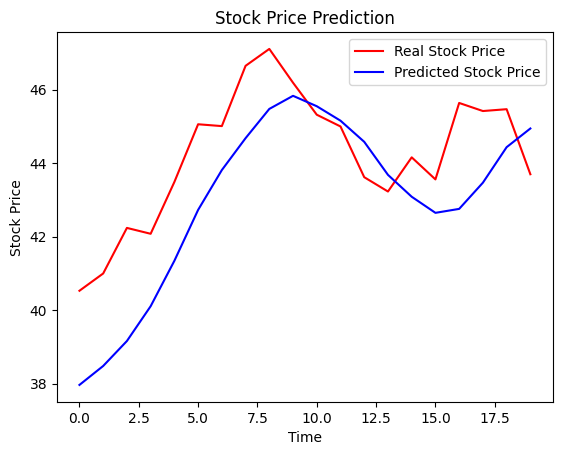

In [543]:
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(model_predictions , color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()